# pybela-pytorch-xc-tutorial tutorial
In this workshop we'll be using jupyter notebooks and python to:
1. Record a dataset of potentiometer sensor values
2. Train a TCN to predict those values
3. Cross-compile and deploy the model to run in real-time in Bela

Connect your Bela to the laptop and run the cell below:

In [9]:
! ssh-keyscan $BBB_HOSTNAME >> ~/.ssh/known_hosts

# 192.168.7.2:22 SSH-2.0-OpenSSH_8.4p1 Debian-5
# 192.168.7.2:22 SSH-2.0-OpenSSH_8.4p1 Debian-5
# 192.168.7.2:22 SSH-2.0-OpenSSH_8.4p1 Debian-5
# 192.168.7.2:22 SSH-2.0-OpenSSH_8.4p1 Debian-5
# 192.168.7.2:22 SSH-2.0-OpenSSH_8.4p1 Debian-5


Let's also import all the necessary python libraries:

In [2]:
import os
from pybela import Logger

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [6]:
!git pull

hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 3), reused 6 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 570 bytes | 285.00 KiB/s, done.
From https://github.com/pelinski/hacklab-pybela
   72e644d..f7e7ebe  main       -> origin/mai

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2 – potentiometers dataset capture

We are now ready to record a dataset with two potentiometers. Connect the second potentiometer to your Bela:

<p align="center">
  <img src="_fritzing/potentiometer_2.png" alt="potentiometer" width="300"/>
</p>

 We will be running the `dataset-capture` project. Now the first potentiometer controls the waveshape of an LFO and the second potentiometer, the volume of the sound.

Let's start by cross-compiling the code and copying it to Bela.

In [13]:
!rm -r code/bela-code/dataset-capture/build

In [14]:
!cd code/bela-code/dataset-capture && cmake -S . -B build -DPROJECT_NAME=dataset-capture -DCMAKE_TOOLCHAIN_FILE=/sysroot/root/Bela/Toolchain.cmake
!cd code/bela-code/dataset-capture && cmake --build build -j

-- The C compiler identification is GNU 10.2.1
-- The CXX compiler identification is GNU 10.2.1
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/arm-linux-gnueabihf-gcc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/arm-linux-gnueabihf-g++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done
-- Generating done
-- Build files have been written to: /root/hacklab/code/bela-code/dataset-capture/build
[ 25%] Building CXX object CMakeFiles/dataset-capture.dir/Watcher.cpp.o
[ 50%] Building CXX object CMakeFiles/dataset-capture.dir/render.cpp.o
[ 75%] Building CXX object CMakeFiles/dataset-capture.dir/sysroot/root/Bela/core/default_main.cpp.o
[100%] Linking CXX executable dataset-capture
[100%] Built target dataset-capture


In [15]:
!rsync -rvL --timeout 10 code/bela-code/dataset-capture/build/dataset-capture root@$BBB_HOSTNAME:Bela/projects/dataset-capture/
!rsync -rvL --timeout 10 code/bela-code/dataset-capture/  --exclude="build" root@$BBB_HOSTNAME:/root/Bela/projects/dataset-capture/

sending incremental file list
dataset-capture

sent 4,612 bytes  received 6,809 bytes  22,842.00 bytes/sec
total size is 1,263,464  speedup is 110.63
sending incremental file list
CMakeLists.txt
Watcher.cpp
Watcher.h
render.cpp

sent 468 bytes  received 354 bytes  548.00 bytes/sec
total size is 28,490  speedup is 34.66


Now you can run the `dataset-capture` project on the Bela:

```bash
ssh root@bela.local
cd Bela/projects/dataset-capture && ./dataset-capture
```

Feel free to play around with the potentiometer and the piezo sensor. You can also edit the code in the IDE and re-run the project.

Once you're ready. You can record a dataset of potentiometer and piezo sensor values.

In [16]:
logger=Logger(ip=os.environ["BBB_HOSTNAME"])
logger.connect()

Running in Jupyter notebook. Enabling nest_asyncio.
Connection successful


1

In [32]:
logger.stop_logging()
logger.delete_all_bin_files_in_project()
!rm *.bin

Stopped logging variables ['gIn']...
File '/root/Bela/projects/dataset-capture/gIn.bin' has been removed from Bela.
All .bin files in /root/Bela/projects/dataset-capture have been removed.


You can time the length of your dataset using `asyncio.sleep(time_in_seconds)`. Note we are not using `time.sleep()` because it would block the Jupyter notebook.

In [33]:
variables = ['gIn']
file_paths = logger.start_logging(variables=variables, transfer=False)
logger.wait(60*10)
logger.stop_logging()

Started logging variables ['gIn']... Run stop_logging() to stop logging.
Stopped logging variables ['gIn']...


In [34]:
file_paths

{'local_paths': {},
 'remote_paths': {'gIn': '/root/Bela/projects/dataset-capture/gIn.bin'}}

In [38]:
!rm *.bin

In [39]:
for var in variables:
    logger.copy_file_from_bela(file_paths["remote_paths"][var], var+".bin")

Transferring /root/Bela/projects/dataset-capture/gIn.bin-->gIn.bin... Done.


In [125]:
data={}
for var in variables:
    raw_data = logger.read_binary_file(file_path=var+".bin", timestamp_mode=logger.get_prop_of_var(var, "timestamp_mode"))
    data[var] = [_data for _buffer in raw_data["buffers"] for _data in _buffer["data"]]

#from IPython.display import Audio
#Audio(data[var], rate=22050)



We can now plot the data using matplotlib.

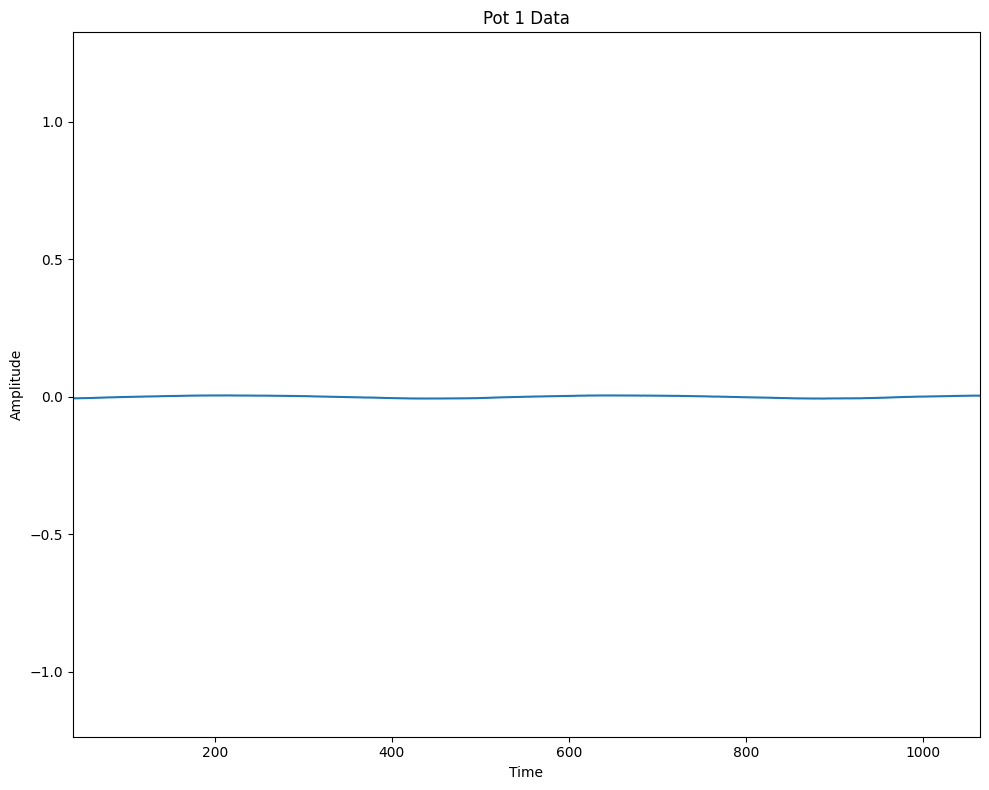

In [97]:

plt.figure(figsize=(10, 8))

plt.plot(np.arange(len(data[var])), data[var])
plt.title('Pot 1 Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.xlim(40,40+1024)
 
plt.tight_layout()
plt.show()

In [98]:
2048/44100

0.046439909297052155

## 3 - train model
Now we are ready to train our model.
We can generate a pytorch compatible dataset using the `SensorDataset` class. This class divides the data you recorded previously in sequences of 512 values.

In [126]:
seq_len = 512
batch_size = 32
target_windows = 1

train_data = data["gIn"]

class PiezoDataset(Dataset):
    def __init__(self, data, seq_len, target_windows):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        # make len divisible by seq_len
        _len = len(data)
        _len = _len - (_len % seq_len)
        data = data[:_len]
        
        # Normalize the data (standard score)
        self.mean = np.mean(data)
        self.std = np.std(data)
        data = (data - self.mean) / self.std
        
        sequences = torch.FloatTensor([data[i:i+seq_len] for i in range(0, len(data), seq_len)])

        self.inputs = sequences[:-target_windows]
        self.inputs = self.inputs.unsqueeze(2).to(self.device) # add feature dim
        outputs=[]
        for idx in range(1, len(sequences)-target_windows+1):
            tgt_seq =sequences[idx:target_windows+idx].flatten()
            outputs.append(tgt_seq)
        self.outputs = torch.stack(outputs).unsqueeze(2).to(self.device)
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, i):
        return self.inputs[i], self.outputs[i]
    
dataset = PiezoDataset(train_data, seq_len, target_windows)
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Using device: cuda


In [127]:
x,y = dataset.__getitem__(0)
dataset.outputs.shape, dataset.inputs.shape, x.shape, y.shape

(torch.Size([25841, 512, 1]),
 torch.Size([25841, 512, 1]),
 torch.Size([512, 1]),
 torch.Size([512, 1]))

Below we define a TCN. We will use an Adam optimiser with a learning rate of 0.001 and use the mean square error as loss.

In [151]:
class ConvNet(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_size, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, input_size, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = x.transpose(1, 2)     # -> (batch, input_size, seq_len)
        x = self.net(x)
        return x.transpose(1, 2)  # -> back to (batch, seq_len, input_size)
# Example usage:
model = ConvNet(input_size=1).to(device)

# Create a batch of 1 with a window of 512 samples
x = torch.randn(1, 512, 1).to(device)

output = model(x)
print(output.shape)  # Should print: torch.Size([1, 512, 1])


torch.Size([1, 512, 1])


We can now train our model:

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction='mean')

epochs = 100

print("Running on device: {}".format(device))

epoch_losses = np.array([])
for epoch in range(1, epochs+1):

    print(">> Epoch: {} <<".format(epoch))

    # training loop
    batch_losses = np.array([])
    model.train()

    for batch_idx, (data, targets) in enumerate(tqdm(dataset_loader)):
        # (batch_size, seq_len, input_size)
        data = data.to(device=device, non_blocking=True)
        # (batch_size, seq_len, input_size)
        targets = targets.to(device=device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # lower memory footprint
        out = model(data)
        loss = criterion(out, targets)
        batch_losses = np.append(batch_losses, loss.item())
        loss.backward()
        optimizer.step()
    
    epoch_losses = np.append(epoch_losses, batch_losses.mean().round(4))

    print(f'Loss: {epoch_losses[-1]}')

Running on device: cuda
>> Epoch: 1 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 623.84it/s]


Loss: 0.741
>> Epoch: 2 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 741.05it/s]


Loss: 0.7275
>> Epoch: 3 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 885.07it/s]


Loss: 0.7246
>> Epoch: 4 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 766.19it/s]


Loss: 0.7247
>> Epoch: 5 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 600.29it/s]


Loss: 0.7234
>> Epoch: 6 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1103.47it/s]


Loss: 0.7241
>> Epoch: 7 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 513.22it/s]


Loss: 0.725
>> Epoch: 8 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 803.15it/s]


Loss: 0.7228
>> Epoch: 9 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 557.27it/s]


Loss: 0.7229
>> Epoch: 10 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 604.71it/s]


Loss: 0.7238
>> Epoch: 11 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1091.37it/s]


Loss: 0.7221
>> Epoch: 12 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1152.53it/s]


Loss: 0.7222
>> Epoch: 13 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 804.14it/s]


Loss: 0.7228
>> Epoch: 14 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 673.09it/s]


Loss: 0.7229
>> Epoch: 15 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1066.74it/s]


Loss: 0.7222
>> Epoch: 16 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 731.55it/s]


Loss: 0.7219
>> Epoch: 17 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 872.35it/s]


Loss: 0.7211
>> Epoch: 18 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 711.20it/s]


Loss: 0.7212
>> Epoch: 19 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 538.75it/s]


Loss: 0.7219
>> Epoch: 20 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 900.88it/s]


Loss: 0.7197
>> Epoch: 21 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 839.59it/s]


Loss: 0.7209
>> Epoch: 22 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1017.58it/s]


Loss: 0.7215
>> Epoch: 23 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1039.68it/s]


Loss: 0.7214
>> Epoch: 24 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 613.33it/s]


Loss: 0.7207
>> Epoch: 25 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1031.83it/s]


Loss: 0.7204
>> Epoch: 26 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 810.94it/s]


Loss: 0.7217
>> Epoch: 27 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1083.10it/s]


Loss: 0.7194
>> Epoch: 28 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 989.82it/s]


Loss: 0.7194
>> Epoch: 29 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 748.67it/s]


Loss: 0.7202
>> Epoch: 30 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1033.73it/s]


Loss: 0.7187
>> Epoch: 31 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 718.73it/s]


Loss: 0.7185
>> Epoch: 32 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 829.66it/s]


Loss: 0.7182
>> Epoch: 33 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 664.08it/s]


Loss: 0.7179
>> Epoch: 34 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 656.81it/s]


Loss: 0.7162
>> Epoch: 35 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1036.26it/s]


Loss: 0.7158
>> Epoch: 36 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 518.65it/s]


Loss: 0.7148
>> Epoch: 37 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 676.96it/s]


Loss: 0.7148
>> Epoch: 38 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 635.57it/s]


Loss: 0.7137
>> Epoch: 39 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 736.07it/s]


Loss: 0.7137
>> Epoch: 40 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 589.65it/s]


Loss: 0.712
>> Epoch: 41 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 742.56it/s]


Loss: 0.7131
>> Epoch: 42 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 787.75it/s]


Loss: 0.7073
>> Epoch: 43 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 779.23it/s]


Loss: 0.7083
>> Epoch: 44 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 858.26it/s]


Loss: 0.7083
>> Epoch: 45 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 773.95it/s]


Loss: 0.7064
>> Epoch: 46 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 660.64it/s]


Loss: 0.7084
>> Epoch: 47 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 757.48it/s]


Loss: 0.7042
>> Epoch: 48 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 816.49it/s]


Loss: 0.7022
>> Epoch: 49 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 744.83it/s]


Loss: 0.7005
>> Epoch: 50 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 775.56it/s]


Loss: 0.7023
>> Epoch: 51 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 588.26it/s]


Loss: 0.7014
>> Epoch: 52 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 516.56it/s]


Loss: 0.6979
>> Epoch: 53 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1116.63it/s]


Loss: 0.6952
>> Epoch: 54 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 641.22it/s]


Loss: 0.6979
>> Epoch: 55 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 790.60it/s]


Loss: 0.6977
>> Epoch: 56 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 920.05it/s]


Loss: 0.6933
>> Epoch: 57 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 825.06it/s]


Loss: 0.6935
>> Epoch: 58 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 633.93it/s]


Loss: 0.6927
>> Epoch: 59 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 734.87it/s]


Loss: 0.6909
>> Epoch: 60 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 933.00it/s]


Loss: 0.692
>> Epoch: 61 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 581.01it/s]


Loss: 0.6905
>> Epoch: 62 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 949.19it/s]


Loss: 0.6887
>> Epoch: 63 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 763.36it/s]


Loss: 0.6926
>> Epoch: 64 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 747.32it/s]


Loss: 0.687
>> Epoch: 65 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 679.49it/s]


Loss: 0.6921
>> Epoch: 66 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 955.37it/s]


Loss: 0.6879
>> Epoch: 67 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 784.30it/s]


Loss: 0.6942
>> Epoch: 68 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 707.04it/s]


Loss: 0.6883
>> Epoch: 69 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 790.04it/s]


Loss: 0.6869
>> Epoch: 70 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 866.24it/s]


Loss: 0.6824
>> Epoch: 71 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 832.58it/s]


Loss: 0.6875
>> Epoch: 72 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 782.41it/s]


Loss: 0.6862
>> Epoch: 73 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 875.48it/s]


Loss: 0.6844
>> Epoch: 74 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1032.82it/s]


Loss: 0.6903
>> Epoch: 75 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 444.42it/s]


Loss: 0.6886
>> Epoch: 76 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 852.85it/s]


Loss: 0.6873
>> Epoch: 77 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1050.98it/s]


Loss: 0.6885
>> Epoch: 78 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 635.38it/s]


Loss: 0.6823
>> Epoch: 79 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 718.82it/s]


Loss: 0.682
>> Epoch: 80 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 651.88it/s]


Loss: 0.683
>> Epoch: 81 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1045.80it/s]


Loss: 0.6814
>> Epoch: 82 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 947.05it/s]


Loss: 0.6955
>> Epoch: 83 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1051.70it/s]


Loss: 0.689
>> Epoch: 84 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1068.03it/s]


Loss: 0.6952
>> Epoch: 85 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 918.41it/s]


Loss: 0.6972
>> Epoch: 86 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 680.28it/s]


Loss: 0.6908
>> Epoch: 87 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1077.47it/s]


Loss: 0.6856
>> Epoch: 88 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 908.38it/s]


Loss: 0.6815
>> Epoch: 89 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1098.78it/s]


Loss: 0.6913
>> Epoch: 90 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1101.21it/s]


Loss: 0.6827
>> Epoch: 91 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1091.33it/s]


Loss: 0.6909
>> Epoch: 92 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 762.90it/s]


Loss: 0.6841
>> Epoch: 93 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 599.09it/s]


Loss: 0.6824
>> Epoch: 94 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 740.37it/s]


Loss: 0.6931
>> Epoch: 95 <<


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1054.35it/s]


Loss: 0.687
>> Epoch: 96 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 894.43it/s]


Loss: 0.6853
>> Epoch: 97 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 687.92it/s]


Loss: 0.6843
>> Epoch: 98 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 800.59it/s]


Loss: 0.6824
>> Epoch: 99 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:01<00:00, 624.22it/s]


Loss: 0.679
>> Epoch: 100 <<


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 947.38it/s]

Loss: 0.6859


We can plot the loss to see how the training went:

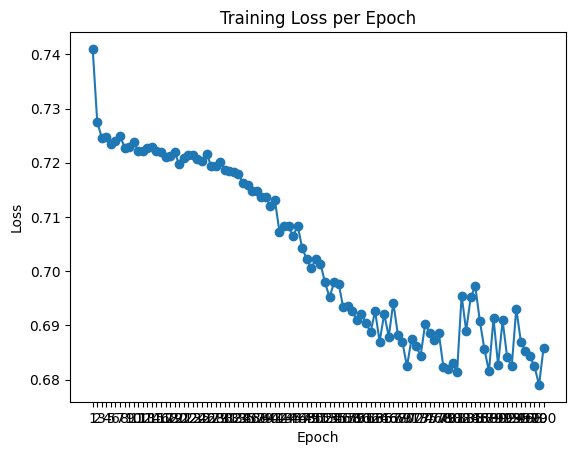

In [153]:
x_epochs = range(1, epochs + 1)

plt.scatter(x_epochs, epoch_losses, marker='o')
plt.plot(x_epochs, epoch_losses, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x_epochs)  # Ensure x-axis has integer values for each epoch
plt.title('Training Loss per Epoch')
plt.show()

Let's make sure the model trained correctly by visualising some of the predictions.

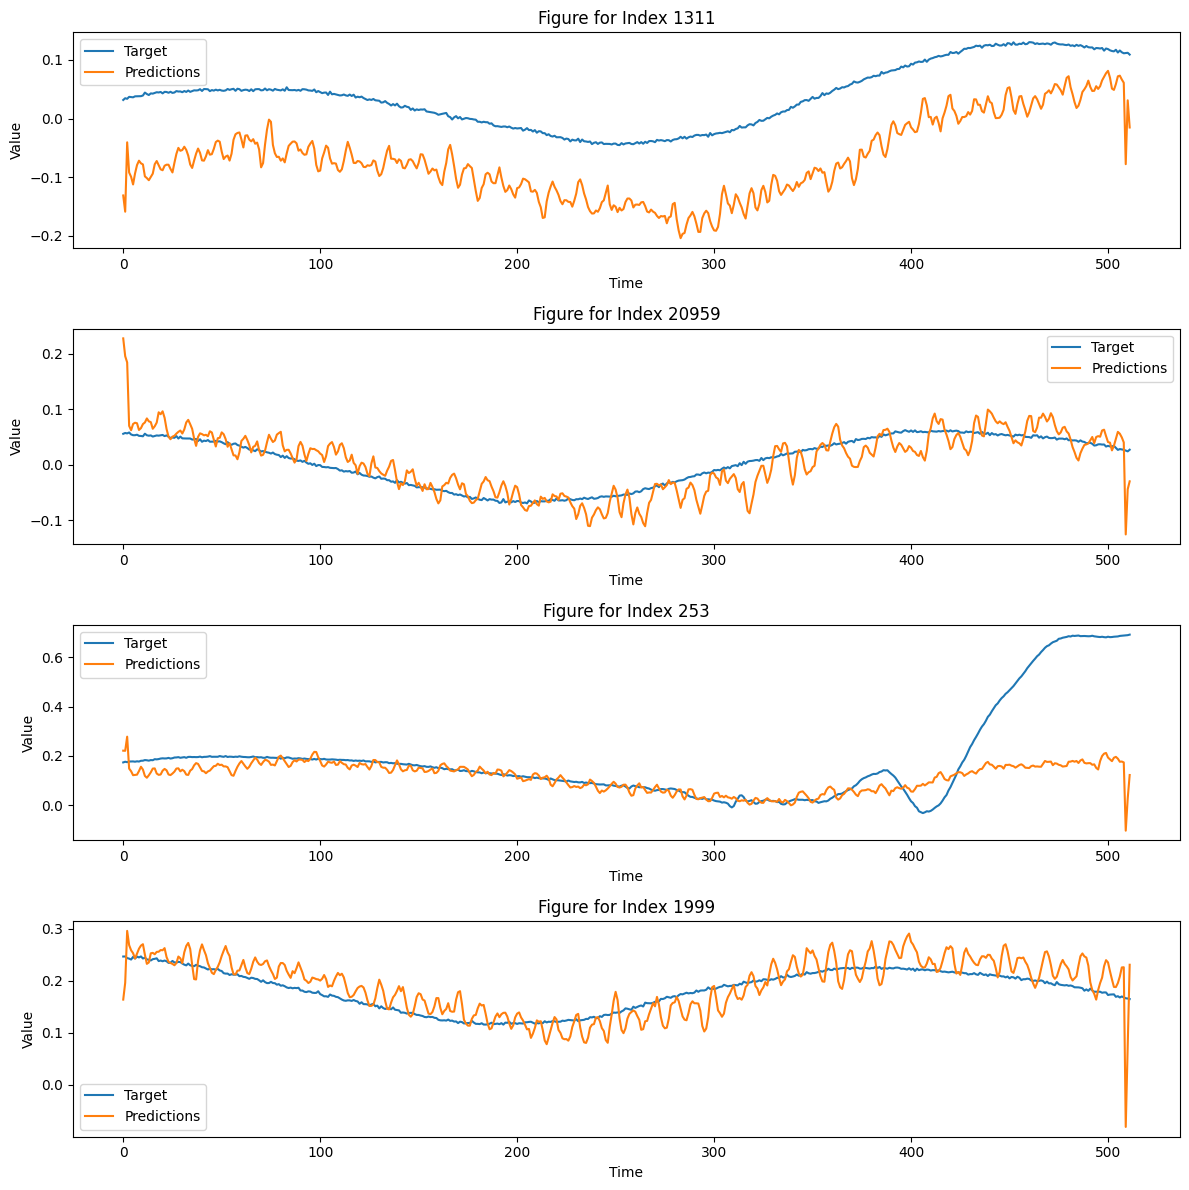

In [172]:
# Select random indexes for plotting
num_examples = 4
random_indexes = np.random.choice(len(dataset), size=num_examples, replace=False)

# Calculate the number of rows for the subplots
num_rows = num_examples

# Set up subplots
fig, axes = plt.subplots(num_rows, 1, figsize=(12, 3 * num_rows))

model = model.to(device)

# Loop through random indexes and plot predictions
for idx, ax_row in zip(random_indexes, axes):
    input, target = dataset.__getitem__(idx)
    output = model(input.unsqueeze(0))
    
    # Plot for the first dimension in the first column
    ax_row.plot(target[:, 0].detach().cpu(), label='Target')
    ax_row.plot(output[0, :, 0].detach().cpu(), label='Predictions')
    ax_row.set_xlabel('Time')
    ax_row.set_ylabel('Value')
    ax_row.legend()
    ax_row.set_title(f'Figure for Index {idx}')
    


plt.tight_layout()
plt.show()

In [155]:
dataset.mean,dataset.std

(-1.860415344092044e-08, 0.08207735935086384)

When you're ready, save the model so that we can export it into Bela.

In [157]:
model.to(device='cpu')
model.eval()
quan_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear, nn.LSTM}, dtype=torch.qint8
)
script = torch.jit.script(model)
path = "code/bela-code/inference/model.jit"
script.save(path)

In [158]:
torch.jit.load(path) # check model is properly saved

RecursiveScriptModule(
  original_name=ConvNet
  (net): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv1d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Conv1d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Conv1d)
  )
)

## 4 - deploy and run

The cell below will cross-compile and deploy the project to Bela.

In [170]:
!cd code/bela-code/inference && cmake -S . -B build -DPROJECT_NAME=inference -DCMAKE_TOOLCHAIN_FILE=/sysroot/root/Bela/Toolchain.cmake
!cd code/bela-code/inference && cmake --build build -j

-- Enabling PyTorch frontend
-- Configuring done
-- Generating done
-- Build files have been written to: /root/hacklab/code/bela-code/inference/build
[ 25%] Building CXX object CMakeFiles/inference.dir/render.cpp.o
[ 50%] Linking CXX executable inference
[100%] Built target inference


In [171]:
!rsync -rvL --timeout 10 code/bela-code/inference/build/inference root@$BBB_HOSTNAME:Bela/projects/inference/
!rsync -rvL --timeout 10 code/bela-code/inference/  --exclude="build" root@$BBB_HOSTNAME:/root/Bela/projects/inference/

sending incremental file list
inference

sent 13,522 bytes  received 13,487 bytes  54,018.00 bytes/sec
total size is 5,003,112  speedup is 185.24
sending incremental file list
CMakeLists.txt
Watcher.cpp
Watcher.h
main.cpp
model.jit
render.cpp
.ipynb_checkpoints/render-checkpoint.cpp

sent 2,312 bytes  received 690 bytes  6,004.00 bytes/sec
total size is 59,361  speedup is 19.77


Once deployed, you can run it from the Bela terminal (which you can access from your regular terminal typing `ssh root@bela.local`) by typing:
```bash
cd Bela/projects/inference
./inference -m model.jit
```